In [1]:
import pandas as pd
from os import chdir, path
import subprocess
import glob
import matplotlib.pyplot as plt
from functools import reduce
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
!module load plink/2.0_alpha_1_final
# local import (Hirotaka's myfunctions.py script)
import myfunctions as myfunc

[-] Unloading plink  1.9.0-beta4.4  on cn4245 
[+] Loading plink  2.0_alpha_1_final 

The following have been reloaded with a version change:
  1) plink/1.9.0-beta4.4 => plink/2.0_alpha_1_final



In [2]:
!mkdir temp4
chdir('temp4')

mkdir: cannot create directory 'temp4': File exists


In [3]:
# Get the id file, covariate file (all European)
# wgsfolder = '/data/CARD/PD/GENOMES/august19/genotypes'
idfile = '_keep.id'

#this is just for larger cohort####
wgsfolder = '/data/CARD/PD/WGS/june2019'
df = pd.read_csv('/data/CARD/PD/WGS/june2019/pd.june2019.chr1.freeze9.sqc.psam', sep='\t')
df['pheno'] = [1 if i=='pd' else 0 for i in df.DX]
df[['#FID', 'IID', 'pheno']].to_csv(idfile, index=False, sep='\t', header=None)
######

# demog = pd.read_csv('/data/LNG/iwakih2/ampPD/data1_out/PP_PD_BF_HB_LC_demog.csv')
# euro = pd.read_csv(f'/data/CARD/PD/GENOMES/august19/genotypes/PCA_filtered_europeans.txt', sep=' ',
#                   header=None, names=['FID', 'IID'])
# df = pd.merge(demog, euro, left_on='WGSID', right_on='IID')
# df['FID'] = df.WGSID
# df['IID'] = df.WGSID
# df.RECRUIT=['CTR' if i=='HC' else i for i in df.RECRUIT]
# df = df[df.RECRUIT.isin(['CTR', 'PD'])]
# df = df[df.RECRUIT==df.LASTDIAG]
# df['pheno'] = [1 if i=='PD' else 0 for i in df.RECRUIT]
# df['AAD'] = df.AADi.where(df.pheno==0, other=df.AAOi)
# df['AGE'] = df.AGEatBL.where(df.pheno==0, other=df.AAD)

# df[['FID', 'IID', 'pheno']].to_csv(idfile, index=False, sep='\t', header=None)
# df[['FID', 'IID', 'AGE', 'FEMALE']].to_csv('_qcovar.txt', index=False, sep='\t', header=None)

In [5]:
df.head()

,#FID,IID,SEX,DX,pheno
0,BF-1101,BF-1101,2,pd,1
1,BF-1102,BF-1102,1,pd,1
2,BF-1001,BF-1001,1,control,0
3,BF-1201,BF-1201,2,pd,1
4,BF-1002,BF-1002,2,pd,1


In [10]:
# used this to generate pca for chr1 just for testing purposes-- prune and merge all chrs first then run PCA
with open('_pca.swarm', 'w') as f:
    for chrnum in range(1,2):
#         pfile = f'{wgsfolder}/pd.june2019.chr{chrnum}.sqc'
        pfile = f'{wgsfolder}/pd.june2019.chr{chrnum}.freeze9.sqc'
        out_pcs = f'chr{chrnum}.pca'
        plink_pca_cmd = f'\
plink2 --pfile {pfile}\
 --pca 80\
 --out {out_pcs}\n'
#         myfunc.shell_do(plink_pca_cmd)
        f.write(plink_pca_cmd)
#         print(plink_pca_cmd)

In [11]:
!swarm -f _pca.swarm -g 64 --time=10:00:00 -t 20 --logdir swarm --module plink/2.0_alpha_1_final --partition=norm

63468668


In [12]:
# now cut up pca for reml
pca = pd.read_csv('chr1.pca.eigenvec', sep='\t')
pca20 = pca.iloc[:,0:22]
pca40 = pca.iloc[:,0:42]
pca80 = pca.iloc[:,0:82]
pca20.to_csv('chr1.pca.20.eigenvec', sep='\t',header=None,index=None)
pca40.to_csv('chr1.pca.40.eigenvec', sep='\t',header=None,index=None)
pca80.to_csv('chr1.pca.80.eigenvec', sep='\t',header=None,index=None)

In [15]:
with open('_script1.swarm', 'w') as f:
    for chrnum in range(1,23):
#         pfile = f'{wgsfolder}/pd.june2019.chr{chrnum}.sqc'
        pfile = f'{wgsfolder}/pd.june2019.chr{chrnum}.freeze9.sqc'
        freqfile = f'freq.{chrnum}'
        plinkcmd = f"\
plink2 --pfile {pfile}\
 --keep {idfile} \
 --freq \
 --out {freqfile}\n"
        f.write(plinkcmd)
#         myfunc.shell_do(plinkcmd)
    f.close()

In [16]:
!swarm -f _script1.swarm -g 64 --time=10:00:00 -t 20 --logdir swarm --module plink/2.0_alpha_1_final --partition=norm

63471415


In [13]:
# now, create grm per chr to make baseline heritability calculation

with open('_baseline_h2_script.swarm', 'w') as f:
    for chrnum in range(1,23):
#         pfile = f'{wgsfolder}/pd.june2019.chr{chrnum}.sqc'
        pfile = f'{wgsfolder}/pd.june2019.chr{chrnum}.freeze9.sqc'
        freqfile = f'freq.{chrnum}'
        plink_out = f'chr{chrnum}'
        
        plinkcmd = f"\
plink2 --pfile {pfile}\
 --make-bed\
 --out {plink_out}"
        
        gctacmd = f'\
gcta64 --bfile {plink_out}\
 --chr {chrnum}\
 --make-grm\
 --out {plink_out}'
        
        f.write(f'{plinkcmd} && {gctacmd}\n')
    f.close()

In [14]:
!swarm -f _baseline_h2_script.swarm -g 64 --time=10:00:00 -t 20 --logdir swarm --module plink/2.0_alpha_1_final --partition=norm

63679153


In [21]:
with open('_baseline_grms.txt', 'w') as f:
    for chrnum in range(1,23):
        chrfile = f'chr{chrnum}'
        f.write(f'{chrfile}\n')
    f.close()


In [24]:
gcta_grm_merge_cmd = 'gcta64 --mgrm _baseline_grms.txt --make-grm --out baseline_grm'
myfunc.shell_do(gcta_grm_merge_cmd)

Executing: gcta64 --mgrm _baseline_grms.txt --make-grm --out baseline_grm


In [25]:
with open('_baseline_reml.swarm', 'w') as f:
    gcta_baseline_reml_cmd = f'\
gcta64 --grm baseline_grm\
 --reml\
 --pheno {idfile}\
 --qcovar chr1.pca.20.eigenvec\
 --out baseline_reml\
 --thread-num 10'
    f.write(gcta_baseline_reml_cmd)
    f.close


In [26]:
!swarm -f _baseline_reml.swarm --time=80:00:00 -g 64 -t 64 --logdir swarm --module plink/2.0_alpha_1_final --partition=norm

63693007


In [7]:
from dask.distributed import Client, progress
# client should match the qued number of threads
client = Client(processes=False, threads_per_worker=2,
                n_workers=2, memory_limit='30GB')
import dask
import dask.dataframe as dd

def MAFbin(x):
    if x>0.075:
        if x<0.3:
            return(1)
        else:
            return(2)
    else:
        return(0)


# def MAFbin(x):
#     if x>0.05:
#         if x<0.25:
#             return(1)
#         else:
#             return(2)
#     else:
#         return(0)







# testing out just 2 maf bins
# def MAFbin(x):
#     if x>0:
#         if x<0.01:
#             return(1)
#         else:
#             return(2)
#     else:
#         return(0)




#try testing fewer maf bins
# def MAFbin(x):
#     if x>0:
#         if x<0.001:
#             return(1)
#         elif x<0.01:
#             return(2)
#         elif x<0.1:
#             return(3)
#         elif x<0.25:
#             return(4)
#         elif x<0.5:
#             return(5)
#         else:
#             return(6)
#     else:
#         return(0)



# def MAFbin(x):
#     if x>0:
#         if x<0.001:
#             return(1)
#         elif x<0.01:
#             return(2)
#         elif x<0.1:
#             return(3)
#         elif x<0.2:
#             return(4)
#         elif x<0.3:
#             return(5)
#         elif x<0.4:
#             return(6)
#         else:
#             return(7)
#     else:
#         return(0)



In [ ]:
# client.close()

In [18]:
# total_counts_df = pd.DataFrame(index=[0,1,2,3,4,5,6])
#test for 2 maf bins
total_counts_df = pd.DataFrame(index=[0,1,2])

for chrnum in range(1,23):
    freqfile = f'freq.{chrnum}'

    df = dd.read_csv(f'{freqfile}.afreq', sep='\t')
    df['MAF'] = df.ALT_FREQS.where(cond=df.ALT_FREQS<=0.5, other=1-df.ALT_FREQS)
    df['Group'] = df.MAF.apply(MAFbin, meta=('MAF', 'float64'))
    for i in range(1,3):
        df.loc[df.Group==i, ['ID']].to_csv(
            f'{freqfile}.mafbin{i}', index=False, single_file=True)
    print(f'chr{chrnum} finished')
    total_counts_df[chrnum] = pd.DataFrame(df.groupby('Group').ID.count().compute())
#     total_counts_df.merge(counts_df, left_index=True)

chr1 finished
chr2 finished
chr3 finished
chr4 finished
chr5 finished
chr6 finished
chr7 finished
chr8 finished
chr9 finished
chr10 finished
chr11 finished
chr12 finished
chr13 finished
chr14 finished
chr15 finished
chr16 finished
chr17 finished
chr18 finished
chr19 finished
chr20 finished
chr21 finished
chr22 finished


In [19]:
# # add chr names
chrs = ['chr' + str(i) for i in range(1,23)]
total_counts_df.columns = chrs

# add bins
# bins = ['0.000', '<0.001', '<0.01', '<0.1', '<0.25', '<0.5', '=0.5']
# bins = ['0.000', '<0.01', '>=0.01']
bins = ['<0.075', '<0.3', '>=0.3']
total_counts_df['bin'] = bins
total_counts_df.set_index('bin', inplace=True)
total_counts_df['total'] = total_counts_df.sum(axis=1)
total_counts_df.to_csv('_maf_bin_counts.txt', sep='\t')
total_counts_df

,chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,...,chr14,chr15,chr16,chr17,chr18,chr19,chr20,chr21,chr22,total
bin,,,,,,,,,,,,,,,,,,,,,
<0.075,10464541,11349494,9377560,9097480,8492737,7963553,7543547,7301007,5732955,6325476,...,4148211,3807050,4280257,3729652,3648716,2850652,2937621,1681727,1771929,129826853
<0.3,249217,276707,235289,243066,211354,222320,190846,178186,143255,168653,...,108681,88623,97052,86645,94801,73946,73507,44667,42471,3267368
>=0.3,155045,163768,145778,148526,131686,136779,119413,110866,83593,101235,...,61187,57330,61228,54329,57460,42760,45550,29383,26798,2010314


In [ ]:
# freqfile = f'freq.21'

# df = pd.read_csv(f'{freqfile}.afreq', sep='\t')
# df['MAF'] = df.ALT_FREQS.where(cond=df.ALT_FREQS<=0.5, other=1-df.ALT_FREQS)


In [ ]:
# df['Group'] = df.MAF.apply(MAFbin)
# df.head()

In [ ]:
# df[df.Group == 6].head()

In [20]:
with open('_script2.swarm', 'w') as f:
    for chrnum in range(1,23):
#         pfile = f'{wgsfolder}/pd.june2019.chr{chrnum}.sqc'
        pfile = f'{wgsfolder}/pd.june2019.chr{chrnum}.freeze9.sqc'
        freqfile = f'freq.{chrnum}'
        for Indx in range(1,3):
            mafbinIndx = f'mafbin{Indx}'
            mafbinfile =  f'{freqfile}.{mafbinIndx}'

            plinkcmd = f"\
plink2 --pfile {pfile}\
 --extract {mafbinfile}\
 --keep {idfile}\
 --make-bed\
 --out {mafbinfile}"
            gctacmd1 = f'\
gcta64 --bfile {mafbinfile}\
 --ld-score-region 10000\
 --out {mafbinfile}.ldbin\
 --thread-num 10'

            f.write(f'{plinkcmd} && {gctacmd1}\n')

In [21]:
!swarm -f _script2.swarm --time=40:00:00 -g 64 -t 64 --logdir swarm --module GCTA,plink/2.0_alpha_1_final --partition=norm

63475427


In [22]:
# need to rerun for jobs that were killed
outputs = glob.glob('freq.*.mafbin*.ldbin.score.ld')
# len(glob.glob('*.ldbin.log'))
expected_out = ['freq.' + str(i) + '.mafbin' + str(j) + '.ldbin.score.ld' for i in range(1,23) for j in range(1,3)]
missing = [bed.replace('.ldbin.score.ld', '') for bed in list(set(expected_out) - set(outputs))]

with open('_rerunscript.swarm', 'w') as f:
    for mafbinfile in missing:
        gctacmd1 = f'\
gcta64 --bfile {mafbinfile}\
 --ld-score-region 10000\
 --out {mafbinfile}.ldbin\
 --thread-num 10'

        f.write(f'{gctacmd1}\n')

In [23]:
!swarm -f _rerunscript.swarm --time=40:00:00 -g 64 -t 10 --logdir swarm --module GCTA --partition=norm

ERROR: No commands in swarmfile _rerunscript.swarm


In [8]:
for chrnum in range(1,23):
#     pfile = f'{wgsfolder}/pd.june2019.chr{chrnum}.sqc'
    pfile = f'{wgsfolder}/pd.june2019.chr{chrnum}.freeze9.sqc'
    
    
    freqfile = f'freq.{chrnum}'
    for Indx in range(1,3):
        mafbinIndx = f'mafbin{Indx}'
        mafbinfile =  f'{freqfile}.{mafbinIndx}'

        # Note this is the ldscore within the maf bin
        df = dd.read_csv(f'{mafbinfile}.ldbin.score.ld', sep=' ')
        ldscvec = df.ldscore_SNP.compute()
        ldscThres = ldscvec.median()
        df['Group'] = 1
        df['Group'] = df.Group.where(cond=df.ldscore_SNP<ldscThres, other=2)


        # Create ldbin and GRMs within the ldbin
        for i in range(1, 3):
            ldbinIndx = f'{mafbinfile}.ldbin{i}'
            df.loc[df.Group==i, ['SNP']].to_csv(
                f'{ldbinIndx}', index=False, single_file=True)
            gctacmd2 = f'\
            gcta64 --bfile {mafbinfile}\
 --extract {ldbinIndx}\
 --make-grm\
 --out {ldbinIndx}'
            myfunc.shell_do(gctacmd2)
            with open('multi_GRMs.txt', 'a') as f:
                f.write(f'{ldbinIndx}\n')
        # mafbin information save to mafbinInfo.csv
        with open('mafbinInfo.txt', 'a') as f:
            s = f'{chrnum}\t{mafbinIndx}\t{len(ldscvec)}\t{ldscvec.mean()}\t{ldscvec.median()}\t{ldscvec.std()}'
            f.write(f'{s}\n')

Executing: gcta64 --bfile freq.1.mafbin1 --extract freq.1.mafbin1.ldbin1 --make-grm --out freq.1.mafbin1.ldbin1
Executing: gcta64 --bfile freq.1.mafbin1 --extract freq.1.mafbin1.ldbin2 --make-grm --out freq.1.mafbin1.ldbin2
Executing: gcta64 --bfile freq.1.mafbin2 --extract freq.1.mafbin2.ldbin1 --make-grm --out freq.1.mafbin2.ldbin1
Executing: gcta64 --bfile freq.1.mafbin2 --extract freq.1.mafbin2.ldbin2 --make-grm --out freq.1.mafbin2.ldbin2
Executing: gcta64 --bfile freq.2.mafbin1 --extract freq.2.mafbin1.ldbin1 --make-grm --out freq.2.mafbin1.ldbin1
Executing: gcta64 --bfile freq.2.mafbin1 --extract freq.2.mafbin1.ldbin2 --make-grm --out freq.2.mafbin1.ldbin2
Executing: gcta64 --bfile freq.2.mafbin2 --extract freq.2.mafbin2.ldbin1 --make-grm --out freq.2.mafbin2.ldbin1
Executing: gcta64 --bfile freq.2.mafbin2 --extract freq.2.mafbin2.ldbin2 --make-grm --out freq.2.mafbin2.ldbin2
Executing: gcta64 --bfile freq.3.mafbin1 --extract freq.3.mafbin1.ldbin1 --make-grm --out freq.3.mafbin1

In [ ]:
# create covar file per chrom and impute missing age (may want to consider dropping age column in this case (missing for more than half))
# impute "FEMALE" with median
# for chrnum in range(1,2):
#     pcs_df = pd.read_csv(f'chr{chrnum}.pca.eigenvec', sep='\t')
#     pcs_df.rename(columns={'#FID':'FID'}, inplace=True)
#     covar_df = df[['FID', 'IID', 'AGE', 'FEMALE']].merge(pcs_df, on=['FID','IID'])
#     covar_df.drop(['AGE','FEMALE'], axis=1, inplace=True)
# #     covar_df.AGE.fillna(covar_df.AGE.mean(), inplace=True)
# #     covar_df.FEMALE.fillna(covar_df.FEMALE.median(),inplace=True)
# #     print(f'dropping {covar_df[covar_df.AGE.isnull()].shape[0]} rows for missing age')
# #     covar_df.dropna(how='any', inplace=True)
#     covar_df.to_csv(f'chr{chrnum}.covar', index=False, sep=' ', header=None)
#     print(f'wrote: chr{chrnum}.covar with {covar_df.shape[0]} samples')

In [ ]:
# covar_df.head()

In [15]:
# count in each ld bin
high_ld_counts_dict = {i:0 for i in range(1,3)}
low_ld_counts_dict = {i:0 for i in range(1,3)}

for chrnum in range(1,23):
    freqfile = f'freq.{chrnum}'
    for Indx in range(1,3):
        mafbinIndx = f'mafbin{Indx}'
        mafbinfile =  f'{freqfile}.{mafbinIndx}'
        for i in range(1, 3):
            ldbinIndx = f'{mafbinfile}.ldbin{i}'
            ldbin_df = pd.read_csv(ldbinIndx,sep='\t')
            if (i == 1):
                low_ld_counts_dict[Indx] += ldbin_df.shape[0]
            else:
                high_ld_counts_dict[Indx] += ldbin_df.shape[0]
       

In [16]:
print(f'high ld counts per maf group: {high_ld_counts_dict}')
print(f'low ld counts per maf group: {low_ld_counts_dict}')
high_df = pd.Series(high_ld_counts_dict).to_frame()
low_df = pd.Series(low_ld_counts_dict).to_frame()
high_df.columns = ['high_ld']
low_df.columns = ['low_ld']
ld_counts_df = high_df.merge(low_df, left_index=True, right_index=True)
# bins = ['<0.001', '<0.01', '<0.1', '<0.25', '<0.5', '=0.5']
bins = ['low','high']
ld_counts_df['maf_bin'] = bins
ld_counts_df.set_index('maf_bin', inplace=True)
ld_counts_df.to_csv('_ld_bin_counts.txt', sep='\t')
ld_counts_df

high ld counts per maf group: {1: 1636535, 2: 1005310}
low ld counts per maf group: {1: 1636504, 2: 1005296}


,high_ld,low_ld
maf_bin,,
low,1636535,1636504
high,1005310,1005296


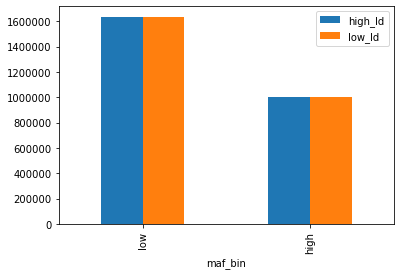

In [20]:
ld_counts_df.plot.bar()


In [ ]:
# --reml-no-lrt\
# --reml-inv-mtd 3\
# run with all maf bins
# gctacmd3 = f'\
# gcta --reml\
#  --mgrm multi_GRMs.txt\
#  --pheno {idfile}\
#  --qcovar chr1.pca.10.eigenvec\
#  --reml-alg 2\
#  --reml-no-constrain\
#  --thread-num 64\
#  --reml-maxit 1000\
#  --out test'
# # myfunc.shell_do(gctacmd3)

# with open('_reml_script.swarm', 'w') as f:
# #     f.write('#!/bin/bash\n')
#     f.write(f'{gctacmd3}\n')

In [ ]:
# !swarm -f _reml_script.swarm --time=80:00:00 -g 64 -t 64 --logdir swarm --module GCTA --partition=norm

In [ ]:
# #set up to run with just maf bins 2-6 as we might not have resolution for maf<0.001
# for chrnum in range(1,23):
#     pfile = f'{wgsfolder}/pd.june2019.chr{chrnum}.sqc'
#     freqfile = f'freq.{chrnum}'
#     for Indx in range(2,6): # leaving last maf bin out for testing!!!! ( will be combined with 0.25<maf<=0.5)
#         mafbinIndx = f'mafbin{Indx}'
#         mafbinfile =  f'{freqfile}.{mafbinIndx}'

        
        

#         # Note this is the ldscore within the maf bin
#         df = dd.read_csv(f'{mafbinfile}.ldbin.score.ld', sep=' ')
#         ldscvec = df.ldscore_SNP.compute()
#         ldscThres = ldscvec.median()
#         df['Group'] = 1
#         df['Group'] = df.Group.where(cond=df.ldscore_SNP<ldscThres, other=2)


#         # Create ldbin and GRMs within the ldbin
#         for i in range(1, 3):
#             ldbinIndx = f'{mafbinfile}.ldbin{i}'

#             with open('2_5_maf_bins_multi_GRMs.txt', 'a') as f:
#                 f.write(f'{ldbinIndx}\n')
#         # mafbin information save to mafbinInfo.csv
#         with open('2_5_mafbinInfo.txt', 'a') as f:
#             s = f'{chrnum}\t{mafbinIndx}\t{len(ldscvec)}\t{ldscvec.mean()}\t{ldscvec.median()}\t{ldscvec.std()}'
#             f.write(f'{s}\n')

In [ ]:
# gctacmd_2_5_maf = f'\
# gcta --reml\
#  --mgrm 2_5_maf_bins_multi_GRMs.txt\
#  --pheno {idfile}\
#  --qcovar chr1.pca.eigenvec\
#  --reml-alg 2\
#  --reml-no-constrain\
#  --thread-num 64\
#  --reml-maxit 1000\
#  --out test_2_5_maf'
# # myfunc.shell_do(gctacmd3)

# with open('2_5_maf_bins_reml_script.swarm', 'w') as f:
# #     f.write('#!/bin/bash\n')
#     f.write(f'{gctacmd_2_5_maf}\n')

In [ ]:
# !swarm -f 2_5_maf_bins_reml_script.swarm --time=80:00:00 -g 64 -t 64 --logdir swarm --module GCTA --partition=norm

In [ ]:
# get estimates for cpu-hrs for analysis
jobs_df = pd.read_csv('../biowulf_user_dashboard.csv')
jobs_df.head(10)

In [ ]:
jobs_df2 = jobs_df[jobs_df.state == 'COMPLETED'][['jobid','cpu', 'cpu_min',
       'cpu_max', 'cpu_avg', 'cpu_util', 'mem', 'mem_min', 'mem_max','elapsed_time']]

jobs_df2['hrs'] = jobs_df2.elapsed_time/3600
jobs_df2['cpu_hrs'] = jobs_df2.cpu * jobs_df2.hrs

In [ ]:
sum(jobs_df2.cpu_hrs)

In [ ]:
# now try merging grms

# !gcta --mgrm multi_GRMs.txt --make-grm --out test_merged_grm

In [ ]:
# gctacmd_merged = f'\
# gcta --reml\
#  --grm test_merged_grm\
#  --pheno {idfile}\
#  --qcovar chr1.pca.eigenvec\
#  --reml-alg 2\
#  --reml-no-constrain\
#  --thread-num 64\
#  --reml-maxit 1000\
#  --out test_merged'

# with open('merged_reml_script.swarm', 'w') as f:
# #     f.write('#!/bin/bash\n')
#     f.write(f'{gctacmd_merged}\n')

In [ ]:
# !swarm -f merged_reml_script.swarm --time=80:00:00 -g 64 -t 64 --logdir swarm --module GCTA --partition=norm

In [ ]:
# keep_ids = pd.read_csv('_keep.id',sep='\t',header=None)

In [ ]:
# keep_ids[2].value_counts()

In [11]:
# now merge chr grms (1 grm per mafbin/ldbin combo: 6 maf bins, 2 ldbins = 12 total grms)

with open('multi_GRMs.merged_chrs.txt', 'w') as mergedGRMlist:
    for Indx in range(1,3): 
        mafbinIndx = f'mafbin{Indx}'
        for i in range(1, 3):
            ldbinIndx = f'{mafbinIndx}.ldbin{i}'
            mergedGRMfile = f'freq.{ldbinIndx}'
            for chrnum in range(1,23):
                freqfile = f'freq.{chrnum}.{ldbinIndx}'
                multiGRMfile = f'multi_GRMs.{ldbinIndx}.txt'
                with open(f'{multiGRMfile}', 'a') as f:
                    f.write(f'{freqfile}\n')
            
            gcta_merge_cmd = f'\
gcta --mgrm {multiGRMfile}\
 --make-grm --out {mergedGRMfile}'
            myfunc.shell_do(gcta_merge_cmd)
            mergedGRMlist.write(f'{mergedGRMfile}\n')       

Executing: gcta --mgrm multi_GRMs.mafbin1.ldbin1.txt --make-grm --out freq.mafbin1.ldbin1
Executing: gcta --mgrm multi_GRMs.mafbin1.ldbin2.txt --make-grm --out freq.mafbin1.ldbin2
Executing: gcta --mgrm multi_GRMs.mafbin2.ldbin1.txt --make-grm --out freq.mafbin2.ldbin1
Executing: gcta --mgrm multi_GRMs.mafbin2.ldbin2.txt --make-grm --out freq.mafbin2.ldbin2


In [ ]:
# #  
# gctacmd_merged_chrs_reml = f'\
# gcta --reml\
#  --mgrm multi_GRMs.merged_chrs.txt\
#  --pheno {idfile}\
#  --qcovar chr1.pca.10.eigenvec\
#  --reml-alg 1\
#  --reml-no-constrain\
#  --thread-num 64\
#  --reml-maxit 1000\
#  --out test_alg1'

# with open('_reml_alg1_script.swarm', 'w') as f:
#     f.write(f'{gctacmd_merged_chrs_reml}\n')

In [ ]:
# !swarm -f _reml_alg1_script.swarm --time=80:00:00 -g 64 -t 64 --logdir swarm --module GCTA --partition=norm

In [ ]:
# gctacmd_merged_chrs_reml = f'\
# gcta --reml\
#  --mgrm multi_GRMs.merged_chrs.txt\
#  --pheno {idfile}\
#  --qcovar chr1.pca.10.eigenvec\
#  --reml-alg 2\
#  --reml-no-constrain\
#  --thread-num 64\
#  --reml-maxit 1000\
#  --out test_alg2'

# with open('_reml_alg2_script.swarm', 'w') as f:
#     f.write(f'{gctacmd_merged_chrs_reml}\n')

In [ ]:
# !swarm -f _reml_alg2_script.swarm --time=80:00:00 -g 64 -t 64 --logdir swarm --module GCTA --partition=norm --devel

In [13]:
!mkdir reml

In [3]:
# now fire off jobs in a loop like gridsearch
# 
param_grid = {'--reml-inv-mtd': [None, 3, 4], 
              '--reml-alg': [0, 1, 2]
             }

In [6]:
# --reml-no-constrain\

reml_gridsearch_cmds = []
reml_gridsearch_outfiles = []
for opts in itertools.product(param_grid['--reml-alg'], param_grid['--reml-inv-mtd']):
    if opts[1]:
        outfile = f'test_alg{opts[0]}_invmtd{opts[1]}_lrt'
        outpath = f'reml/{outfile}'
        gctacmd = f'\
gcta --reml\
 --mgrm multi_GRMs.merged_chrs.txt\
 --pheno {idfile}\
 --qcovar chr1.pca.20.eigenvec\
 --reml-alg {opts[0]}\
 --reml-inv-mtd {opts[1]}\
 --thread-num 64\
 --reml-maxit 1000\
 --out {outpath}'
        
        reml_gridsearch_cmds.append(gctacmd) 
        reml_gridsearch_outfiles.append(outfile)
    else:
        outfile = f'test_alg{opts[0]}'
        outpath = f'reml/{outfile}'
        gctacmd = f'\
gcta --reml\
 --mgrm multi_GRMs.merged_chrs.txt\
 --pheno {idfile}\
 --qcovar chr1.pca.20.eigenvec\
 --reml-alg {opts[0]}\
 --thread-num 64\
 --reml-maxit 1000\
 --out {outpath}'
        reml_gridsearch_cmds.append(gctacmd)
        reml_gridsearch_outfiles.append(outfile)

In [8]:
with open('reml_gridsearch.swarm', 'w') as f:
    for cmd in reml_gridsearch_cmds:
        f.write(f'{cmd}\n')

In [9]:
!swarm -f reml_gridsearch.swarm --time=80:00:00 -g 64 -t 64 --logdir swarm --module GCTA --partition=norm

63561917


Text(0.5, 1.0, 'H^2 Standard Error Per Maf/LD Group Per Algorithm')

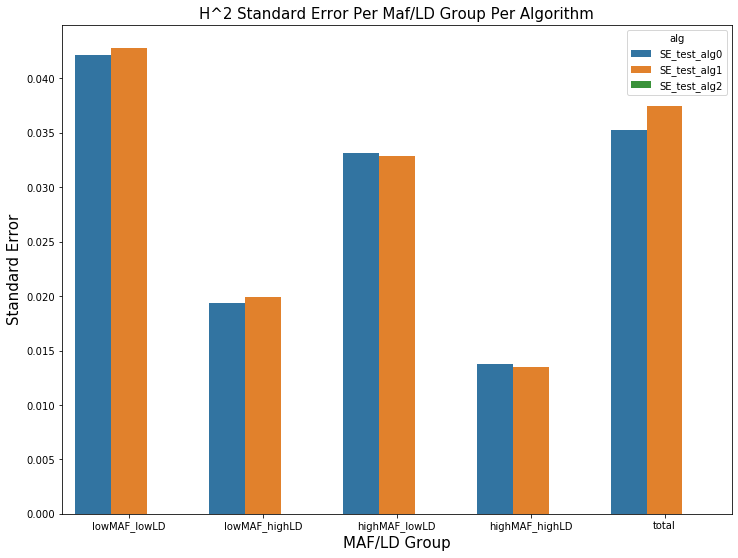

In [17]:
gridsearch_dfs = []
for file in reml_gridsearch_outfiles:
    if path.exists(f'reml/{file}.hsq'):
        hsq = pd.read_csv(f"reml/{file}.hsq", sep="\t")
        hsq.columns = ["Source", f"Variance_{file}", f"SE_{file}"]
        gridsearch_dfs.append(hsq)
    
hsq = reduce(lambda left,right: pd.merge(left,right,on='Source'), gridsearch_dfs)
hsq2 = hsq.iloc[6:11,:].reset_index().drop('index',axis=1)
hsq2['maf'] = ['low','low','high','high','total']
hsq2['ld'] = ['low','high','low','high','total']
hsq2['maf_ld_group'] = ['lowMAF_lowLD','lowMAF_highLD','highMAF_lowLD','highMAF_highLD','total']
se_columns = [f'SE_{file}' for file in reml_gridsearch_outfiles]
se_columns.insert(0,'maf_ld_group')

# add zeros for columns of algorithms that did not converge
for col in se_columns:
    if col not in hsq2.columns:
        hsq2[col] = 0
    else:
        pass
# now, grab only se    
hsq_se = hsq2[se_columns]

# we can visually see that the invmtd methods didnt result in different SE so lets just do 1 plot for each alg
hsq_se_final = hsq_se[['maf_ld_group', 'SE_test_alg0', 'SE_test_alg1', 'SE_test_alg2']]
hsq_se_melt = pd.melt(hsq_se_final, id_vars=['maf_ld_group'], value_vars=['SE_test_alg0', 'SE_test_alg1', 'SE_test_alg2'])
hsq_se_melt.rename(columns={'value':'SE', 'variable':'alg'}, inplace=True)
hsq_se_melt

plt.figure(figsize=(12, 9))
se_plot = sns.barplot(x="maf_ld_group", hue="alg", y="SE", data=hsq_se_melt)
se_plot.set_xlabel("MAF/LD Group",fontsize=15)
se_plot.set_ylabel("Standard Error", fontsize=15)
se_plot.set_title("H^2 Standard Error Per Maf/LD Group Per Algorithm", fontsize=15)

In [4]:
# choose one that works from gridsearch
# run for each number of pcs
# --reml-no-constrain\

with open('multi_pcs_reml.swarm', 'w') as f:
    for i in [20,40,80]:
        
        remlcmd = f'\
gcta --reml\
 --mgrm multi_GRMs.merged_chrs.txt\
 --pheno _keep.id\
 --qcovar chr1.pca.{i}.eigenvec\
 --reml-alg 0\
 --thread-num 64\
 --reml-maxit 1000\
 --out reml/reml_2maf_alg0_{i}pcs'
        
        f.write(f'{remlcmd}\n')
    

In [5]:
!swarm -f multi_pcs_reml.swarm --time=80:00:00 -g 64 -t 64 --logdir swarm --module GCTA --partition=norm

63587480


In [4]:
# plotting H^2
dfs = []
for i in [20,40,80]:
    hsq = pd.read_csv(f"reml/reml_2maf_alg0_{i}pcs.hsq", sep="\t")
    hsq.columns = ["Source", f"Variance{i}", f"SE{i}"]
    dfs.append(hsq)
# hsq20 = pd.read_csv("reml/reml_2maf_alg0_20pcs.hsq", sep="\t")
# hsq40 = pd.read_csv("reml/reml_2maf_alg0_40pcs.hsq", sep="\t")
# hsq80 = pd.read_csv("reml/reml_2maf_alg0_80pcs.hsq", sep="\t")

# dfs = [hsq20, hsq40, hsq80]
hsq = reduce(lambda left,right: pd.merge(left,right,on='Source'), dfs)
hsq2 = hsq.iloc[6:11,:].reset_index().drop('index',axis=1)
hsq2['maf_ld_group'] = ['mafbin1_ldbin1','mafbin1_ldbin2','mafbin2_ldbin1','mafbin2_ldbin2','total']
hsq2['maf'] = ['low_maf','low_maf','high_maf','high_maf','total']
# ['0.0001-0.01', '0.0001-0.01', '0.01-0.5', '0.01-0.5','total']
hsq2['ld'] = ['low_ld','high_ld','low_ld','high_ld','']
hsq2.rename(columns={'Variance20':'20_PCs','Variance40':'40_PCs','Variance80':'80_PCs'}, inplace=True)
hsq2.head()


,Source,20_PCs,SE20,40_PCs,SE40,80_PCs,SE80,maf_ld_group,maf,ld
0,V(G1)/Vp,0.273448,0.042179,0.273160,0.042201,0.270713,0.042304,mafbin1_ldbin1,low_maf,low_ld
1,V(G2)/Vp,0.113258,0.019351,0.114859,0.019415,0.116279,0.019507,mafbin1_ldbin2,low_maf,high_ld
2,V(G3)/Vp,0.076295,0.033151,0.076758,0.033193,0.076682,0.033249,mafbin2_ldbin1,high_maf,low_ld
3,V(G4)/Vp,0.011864,0.013760,0.011459,0.013743,0.011016,0.013768,mafbin2_ldbin2,high_maf,high_ld
4,Sum of V(G)/Vp,0.474866,0.035283,0.476236,0.035297,0.474690,0.035352,total,total,


In [5]:
# hsq_var = hsq2[["Variance20","Variance40","Variance80","maf","ld"]]
# hsq_melt = pd.melt(hsq2, id_vars=['maf','ld','SE20','SE40','SE80'], value_vars=['20_PCs','40_PCs','80_PCs'])
# hsq_melt.rename(columns={'variable':'PCs','value':'Heritability'},inplace=True)
# hsq_melt2 = pd.melt(hsq_melt, id_vars=['maf','ld','PCs','Heritability'], value_vars=['SE20','SE40','SE80'])
# hsq_melt2.rename(columns={'value':'SE'}, inplace=True)
# hsq_20 = hsq_melt2[hsq_melt2.PCs.str.contains('20') & hsq_melt2.variable.str.contains('20')]
# hsq_40 = hsq_melt2[hsq_melt2.PCs.str.contains('40') & hsq_melt2.variable.str.contains('40')]
# hsq_80 = hsq_melt2[hsq_melt2.PCs.str.contains('80') & hsq_melt2.variable.str.contains('80')]
# hsq_final = hsq_20.append(hsq_40.append(hsq_80))
# hsq_final.reset_index(drop=True, inplace=True)
# low = hsq_final[hsq_final.ld=='low']
# high = hsq_final[hsq_final.ld=='high']
low = hsq2[hsq2.ld=='low_ld']
high = hsq2[hsq2.ld=='high_ld']
total = hsq2[hsq2.maf=='total']

In [6]:
# import plotly.graph_objects as go
# # import plotly.offline as pyo
# # pyo.init_notebook_mode()
# import plotly
# plotly.offline.init_notebook_mode(connected=True)

# # fig = go.Figure()
# fig=go.FigureWidget()

# x = [hsq2['maf'],hsq2['ld']]

# fig.add_trace(go.Bar(
#     name='20 PCs',
#     x=x, y=hsq2['20_PCs']))

# fig.add_trace(go.Bar(
#     name='40 PCs',
#     x=x, y=hsq2['40_PCs']))

# fig.add_trace(go.Bar(
#     name='80 PCs',
#     x=x, y=hsq2['80_PCs']))

# fig.write_html('rare_vars_075_3.html', auto_open=True)
# fig.show()


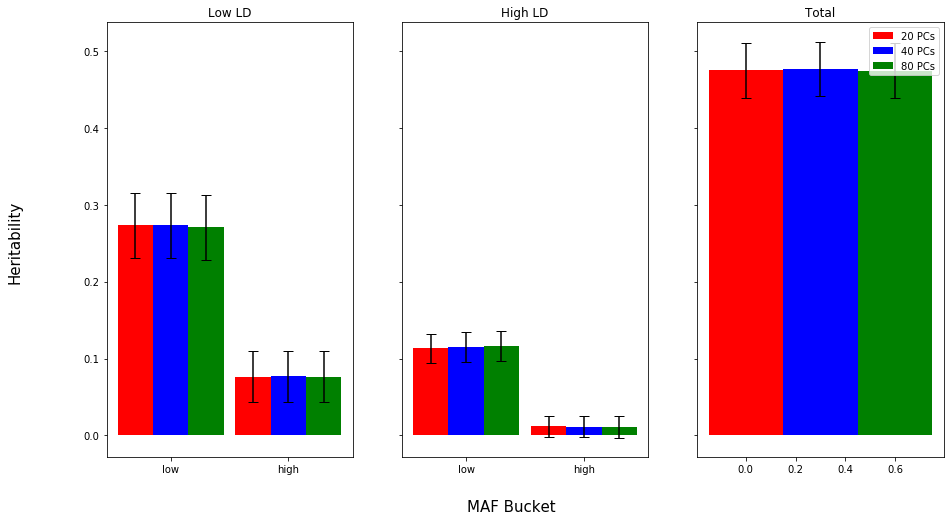

In [9]:

# colors = {'20_PCs':'red', '40_PCs':'blue', '80_PCs':'green'}
barWidth = 0.3
r1 = np.arange(len(low.maf))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
u = low['maf']
x = np.arange(len(u))

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, sharex=False)
fig.set_figheight(8)
fig.set_figwidth(15)


low1 = ax1.bar(r1, low['20_PCs'], width = barWidth, yerr=low['SE20'], capsize=5, color='red')
low2 = ax1.bar(r2, low['40_PCs'], width = barWidth, yerr=low['SE40'], capsize=5, color='blue')
low3 = ax1.bar(r3, low['80_PCs'], width = barWidth, yerr=low['SE80'], capsize=5, color='green')
ax1.title.set_text('Low LD')


high1 = ax2.bar(r1, high['20_PCs'], width = barWidth, yerr=high['SE20'], capsize=5, color='red')
high2 = ax2.bar(r2, high['40_PCs'], width = barWidth, yerr=high['SE40'], capsize=5, color='blue')
high3 = ax2.bar(r3, high['80_PCs'], width = barWidth, yerr=high['SE80'], capsize=5, color='green')
ax2.title.set_text('High LD')

plt.legend(handles=[low1, low2, low3], labels=['20 PCs', '40 PCs', '80 PCs'], loc="upper right")
plt.setp((ax1, ax2), xticks=[0.3, 1.3], xticklabels=['low', 'high'])
fig.text(0.5, 0.04, 'MAF Bucket', va='center', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Heritability', va='center', ha='center', rotation='vertical', fontsize=15)

total1 = ax3.bar(0, total['20_PCs'], width = barWidth, yerr=total['SE20'], capsize=5, color='red')
total2 = ax3.bar(.3, total['40_PCs'], width = barWidth, yerr=total['SE20'], capsize=5, color='blue')
total3 = ax3.bar(.6, total['80_PCs'], width = barWidth, yerr=total['SE20'], capsize=5, color='green')
ax3.title.set_text('Total')



# barWidth = 0.3
# r1 = np.arange(len(low.maf))
# r2 = [x + barWidth for x in r1]
# r3 = [x + barWidth for x in r2]
# u = low['maf']
# x = np.arange(len(u))

# fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, sharex=True)
# fig.set_figheight(8)
# fig.set_figwidth(15)


# low1 = ax1.bar(r1, low['20_PCs'], width = barWidth, yerr=low['SE20'], capsize=5, color='red')
# low2 = ax1.bar(r2, low['40_PCs'], width = barWidth, yerr=low['SE40'], capsize=5, color='blue')
# low3 = ax1.bar(r3, low['80_PCs'], width = barWidth, yerr=low['SE80'], capsize=5, color='green')
# ax1.title.set_text('Low LD')


# high1 = ax2.bar(r1, high['20_PCs'], width = barWidth, yerr=high['SE20'], capsize=5, color='red')
# high2 = ax2.bar(r2, high['40_PCs'], width = barWidth, yerr=high['SE40'], capsize=5, color='blue')
# high3 = ax2.bar(r3, high['80_PCs'], width = barWidth, yerr=low['SE80'], capsize=5, color='green')
# ax2.title.set_text('High LD')

# plt.legend(handles=[low1, low2, low3], labels=['20 PCs', '40 PCs', '80 PCs'], loc="upper right")
# plt.setp((ax1, ax2), xticks=[0.3, 1.3], xticklabels=['low', 'high'])
# fig.text(0.5, 0.04, 'MAF Bucket', va='center', ha='center', fontsize=15)
# fig.text(0.04, 0.5, 'Heritability', va='center', ha='center', rotation='vertical', fontsize=15)





# fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
# fig.set_figheight(8)
# fig.set_figwidth(15)
# sns.barplot(low.maf, low.Heritability, hue=low.PCs, ax=ax1)
# ax1.title.set_text("Low LD")

# sns.barplot(high.maf, high.Heritability, hue=high.PCs, ax=ax2)
# ax2.title.set_text("High LD")

In [9]:
# now, test with Haseman-Elston (HE) regression
!gcta64 --HEreg --mgrm multi_GRMs.merged_chrs.txt --pheno _keep.id --out test_hereg

*******************************************************************
* Genome-wide Complex Trait Analysis (GCTA)
* version 1.93.0 beta Linux
* (C) 2010-2019, The University of Queensland
* Please report bugs to Jian Yang <jian.yang@uq.edu.au>
*******************************************************************
Analysis started at 15:45:09 UTC on Mon Aug 24 2020.
Hostname: biowulf.nih.gov

Accepted options:
--HEreg
--mgrm multi_GRMs.merged_chrs.txt
--pheno _keep.id
--out test_hereg

Note: This is a multi-thread program. You could specify the number of threads by the --thread-num option to speed up the computation if there are multiple processors in your machine.

Reading IDs of the GRM from [freq.mafbin1.ldbin1.grm.id].
9282 IDs read from [freq.mafbin1.ldbin1.grm.id].
Reading IDs of the GRM from [freq.mafbin1.ldbin2.grm.id].
9282 IDs read from [freq.mafbin1.ldbin2.grm.id].
Reading IDs of the GRM from [freq.mafbin2.ldbin1.grm.id].
9282 IDs read from [freq.mafbin2.ldbin1.grm.id].
Reading ID